# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
  
  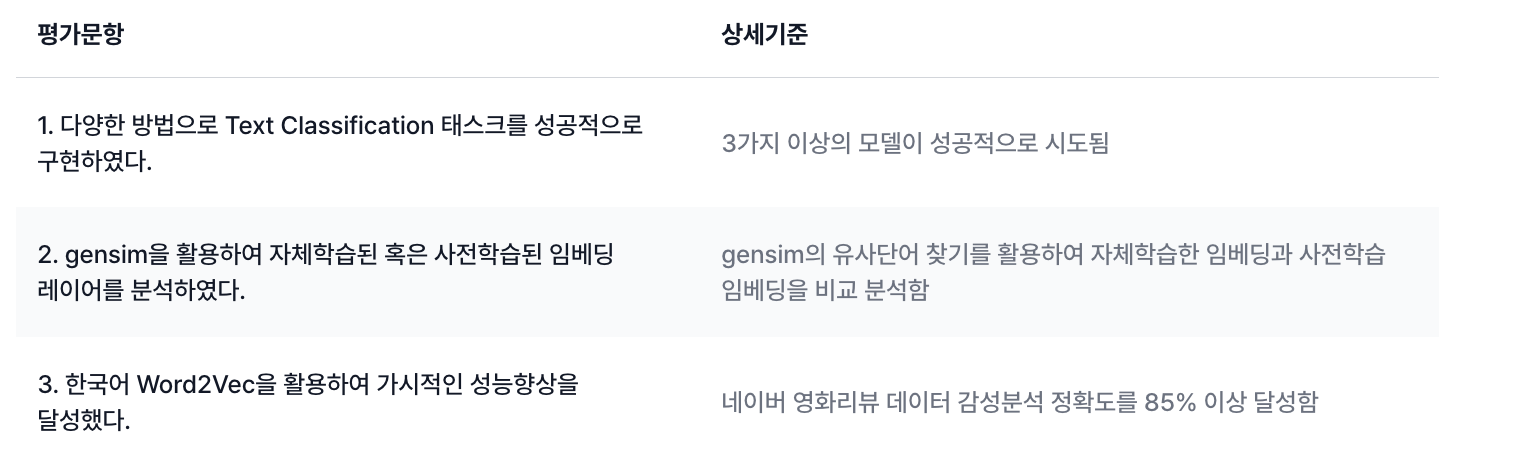

In [134]:
import pandas
import konlpy
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 1) 데이터 준비와 확인

In [135]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [136]:
print('훈련데이터:',len(train_data),', 테스트테이터:', len(test_data))

훈련데이터: 150000 , 테스트테이터: 50000


> id는 쓸모없는 정보니까 삭제, document, label만 사용하기로 한다

# 2) 데이터로더 구성
- 실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.  


- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [137]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

- 중복되는 데이터가 있음을 발견했다

In [138]:
#중복 제거, 빈 값 제거, 정수인코딩까지 한 번에 해줬다

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [139]:
print(X_train[:3], X_test[:3], y_train[:3], y_test[:3])

[[32, 74, 919, 4, 4, 39, 228, 20, 33, 748], [1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391], [24, 205, 3]] [[832, 130], [3], [85, 111, 58, 4, 70, 950, 332, 44, 38, 100, 37, 641, 3557, 73, 917]] [0 1 0] [1 0 0]


In [140]:
print(f"훈련샘플 갯수: {len(X_train)}, 테스트갯수: {len(X_test)}")

훈련샘플 갯수: 146182, 테스트갯수: 49157


In [141]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [142]:
#패딩 추가 !! (실제 인코딩 인덱스가 밀려있으므로)
word_to_index['<PAD>']= 0  # 패딩용 단어
word_to_index['<BOS>']= 1  # 문장의 시작지점
word_to_index['<UNK>']= 2  # 사전에 없는(Unknown) 단어

In [143]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [144]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [145]:
#한 번 테스트 해본다
print(get_decoded_sentence(X_train[3], index_to_word))

이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정


In [146]:
print('1번째 리뷰 문장 길이 : ',len(X_train[0]))
print('2번째 리뷰 문장 길이 : ',len(X_test[1]))

1번째 리뷰 문장 길이 :  10
2번째 리뷰 문장 길이 :  1


> 💡 평균 문장길이를 참고하여, maxlen을 지정해주겠다

# 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [147]:
#데이터셋 내 문장길이 분포, 적절한 최대 문장 길이 지정

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [148]:
#패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


# 4) 모델 구성, 훈련
- 모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

## 모델1.
- 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용
- 손실 함수로 크로스 엔트로피 함수를 사용. 
- 하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행.
- callback 에는 es(early stopping), mc(model checkpoint)를 적용했다. 조기종료 / 모델상태 저장

In [173]:
#Model 1 - LSTM
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
embedding_dim = 16 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
hidden_units = 128

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_shape=(None, )))
model1.add(LSTM(hidden_units))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history1 = model1.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1828/1828 [==============================] - 13s 7ms/step - loss: 0.4090 - acc: 0.8141 - val_loss: 0.3549 - val_acc: 0.8446

Epoch 00001: val_acc improved from -inf to 0.84461, saving model to best_model.h5
Epoch 2/15
1828/1828 [==============================] - 12s 6ms/step - loss: 0.3361 - acc: 0.8543 - val_loss: 0.3339 - val_acc: 0.8537

Epoch 00002: val_acc improved from 0.84461 to 0.85368, saving model to best_model.h5
Epoch 3/15
1828/1828 [==============================] - 12s 7ms/step - loss: 0.3115 - acc: 0.8666 - val_loss: 0.3201 - val_acc: 0.8611

Epoch 00003: val_acc improved from 0.85368 to 0.86113, saving model to best_model.h5
Epoch 4/15
1828/1828 [==============================] - 12s 6ms/step - loss: 0.2972 - acc: 0.8737 - val_loss: 0.3153 - val_acc: 0.8636

Epoch 00004: val_acc improved from 0.86113 to 0.86363, saving model to best_model.h5
Epoch 5/15
1828/1828 [==============================] - 12s 6ms/step - loss: 0.2878 - acc: 0.8792 - val_loss: 0.3107 - 

- 정확도가 train 91%, validation 86%까지 나왔다

## 모델2. 

In [189]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
embedding_dim = 16 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
hidden_units = 128

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [191]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history2 = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1828/1828 [==============================] - 9s 4ms/step - loss: 0.3948 - acc: 0.8172 - val_loss: 0.3369 - val_acc: 0.8546

Epoch 00001: val_acc did not improve from 0.87075
Epoch 2/15
1828/1828 [==============================] - 8s 4ms/step - loss: 0.2951 - acc: 0.8762 - val_loss: 0.3330 - val_acc: 0.8587

Epoch 00002: val_acc did not improve from 0.87075
Epoch 3/15
1828/1828 [==============================] - 8s 4ms/step - loss: 0.2408 - acc: 0.9025 - val_loss: 0.3438 - val_acc: 0.8567

Epoch 00003: val_acc did not improve from 0.87075
Epoch 4/15
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1885 - acc: 0.9287 - val_loss: 0.3893 - val_acc: 0.8508

Epoch 00004: val_acc did not improve from 0.87075
Epoch 5/15
1828/1828 [==============================] - 8s 4ms/step - loss: 0.1463 - acc: 0.9464 - val_loss: 0.4468 - val_acc: 0.8452

Epoch 00005: val_acc did not improve from 0.87075
Epoch 6/15
1828/1828 [==============================] - 8s 4ms/step - loss:

- 정확도가 train 95%, validation 84%까지 나왔다

## 모델3.

In [176]:
#훈련            
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim))
model3.add(LSTM(hidden_units))
model3.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history3 = model3.fit(X_train, y_train, epochs=epochs, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/20
1828/1828 [==============================] - 13s 6ms/step - loss: 0.4029 - acc: 0.8182 - val_loss: 0.3620 - val_acc: 0.8395

Epoch 00001: val_acc improved from -inf to 0.83945, saving model to best_model.h5
Epoch 2/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3365 - acc: 0.8543 - val_loss: 0.3301 - val_acc: 0.8562

Epoch 00002: val_acc improved from 0.83945 to 0.85624, saving model to best_model.h5
Epoch 3/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.3125 - acc: 0.8666 - val_loss: 0.3180 - val_acc: 0.8623

Epoch 00003: val_acc improved from 0.85624 to 0.86233, saving model to best_model.h5
Epoch 4/20
1828/1828 [==============================] - 11s 6ms/step - loss: 0.2979 - acc: 0.8742 - val_loss: 0.3138 - val_acc: 0.8658

Epoch 00004: val_acc improved from 0.86233 to 0.86575, saving model to best_model.h5
Epoch 5/20
1828/1828 [==============================] - 12s 6ms/step - loss: 0.2880 - acc: 0.8786 - val_loss: 0.3139 - 

- 이번에는 train 정확도: 90%, validation 정확도: 86%

# 5) 모델 평가

In [177]:
#마지막 학습 끝낸 모델을 테스트셋으로 평가
results1 = model1.evaluate(X_test, y_test, verbose=2)
results2 = model2.evaluate(X_test, y_test, verbose=2)
results3 = model3.evaluate(X_test, y_test, verbose=2)

print(f'테스트 1 정확도: {results1[1]*100:.2f}%')
print(f'테스트 2 정확도: {results2[1]*100:.2f}%')
print(f'테스트 3 정확도: {results3[1]*100:.2f}%')

1537/1537 - 3s - loss: 0.3405 - acc: 0.8583
1537/1537 - 3s - loss: 0.5041 - accuracy: 0.8396
1537/1537 - 3s - loss: 0.3245 - acc: 0.8622
테스트 1 정확도: 85.83%
테스트 2 정확도: 83.96%
테스트 3 정확도: 86.22%


- verbose=0: 아무런 출력도 하지 않습니다.
- verbose=1: 훈련 진행 상황을 진행 막대(progress bar) 형태로 표시합니다.
- verbose=2: 한 번에 한 에포크마다 한 줄씩 훈련 진행 상황을 출력합니다.

In [192]:
history_dict1 = history1.history
history_dict2 = history2.history
history_dict3 = history3.history

print(history_dict2.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


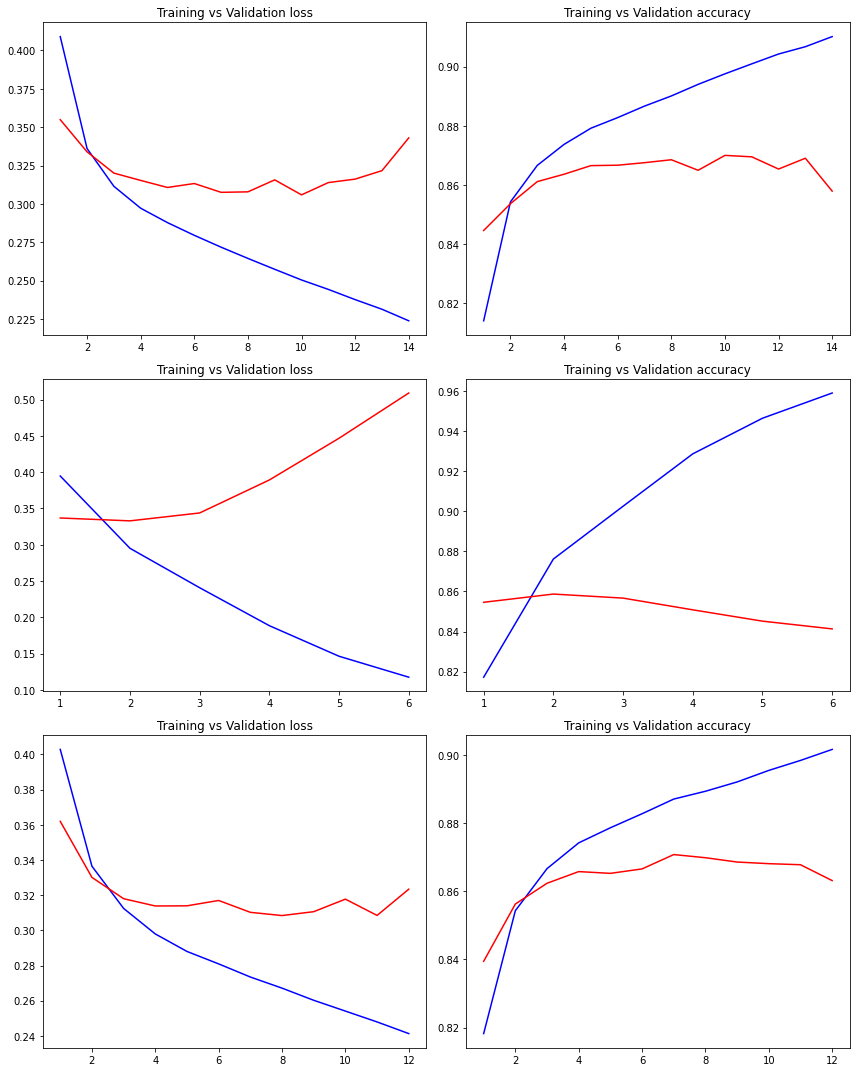

In [194]:
history_dicts = [history_dict1, history_dict2, history_dict3]



fig, axes = plt.subplots(len(history_dicts), 2,figsize=(12,5*len(history_dicts)))

for i, history_dict in enumerate(history_dicts):
    acc= history_dict['acc']
    val_acc= history_dict['val_acc']
    loss= history_dict['loss']
    val_loss= history_dict['val_loss']
    epochs = range(1, len(acc)+1)

    ax1= axes[i][0]
    ax2= axes[i][1]

    ax1.plot(epochs, loss, 'b', label='Training loss')
    ax1.plot(epochs, val_loss, 'r', label='Validation loss')
    ax1.set_title('Training vs Validation loss')

    ax2.plot(epochs, acc, 'b', label='Training accuracy')
    ax2.plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax2.set_title('Training vs Validation accuracy')
    
plt.tight_layout()
plt.show()

# 6) 학습된 Embedding 레이어 분석

In [197]:
embedding_layer = model3.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [198]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [204]:
#Genism 패키지를 활용해, 임베딩 파라미터를 읽어 word vector로 활용 
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['재미']
vector

array([ 0.01134547, -0.16916999,  0.13763137, -0.17423801,  0.08550129,
        0.08807762, -0.00654247, -0.02679759, -0.11139811,  0.09670486,
        0.01509513, -0.0174416 ,  0.2585948 ,  0.15270606,  0.1600274 ,
       -0.11400057], dtype=float32)

In [205]:
word_vectors.similar_by_word("재미")

[('밝히', 0.89605313539505),
 ('서정', 0.8382034301757812),
 ('아하', 0.8037914037704468),
 ('포켓몬', 0.8014235496520996),
 ('겁내', 0.8010008335113525),
 ('버', 0.7979848980903625),
 ('능', 0.7973355650901794),
 ('자마자', 0.7844972014427185),
 ('내내', 0.7817763686180115),
 ('데미무어', 0.7816449999809265)]

# 7) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 


In [216]:
afrom tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)               

In [217]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 11ms/step - loss: 0.6917 - accuracy: 0.5256 - val_loss: 0.6804 - val_accuracy: 0.5103
Epoch 2/20
229/229 [==============================] - 2s 8ms/step - loss: 0.5114 - accuracy: 0.7486 - val_loss: 0.4052 - val_accuracy: 0.8203
Epoch 3/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3664 - accuracy: 0.8412 - val_loss: 0.3851 - val_accuracy: 0.8289
Epoch 4/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3305 - accuracy: 0.8602 - val_loss: 0.3713 - val_accuracy: 0.8370
Epoch 5/20
229/229 [==============================] - 2s 8ms/step - loss: 0.3011 - accuracy: 0.8744 - val_loss: 0.4099 - val_accuracy: 0.8198
Epoch 6/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2807 - accuracy: 0.8849 - val_loss: 0.3899 - val_accuracy: 0.8314
Epoch 7/20
229/229 [==============================] - 2s 8ms/step - loss: 0.2600 - accuracy: 0.8955 - val_loss: 0.3799 - val_accuracy: 0.8400
Epoch

In [218]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6823 - accuracy: 0.8097
[0.6822954416275024, 0.8097320795059204]


## Word2Vec 적용

In [234]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'

from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [244]:
vocab_size = 10000
word_vector_dim = 16
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습 벡터를 복사할 더미를 만듭니다.

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 차례대로 카피합니다.
for i in range(4, vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]
    
from tensorflow.keras.initializers import Constant


# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 16)            160000    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 35, 16)            1808      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

/tmp/ipykernel_41/172942955.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_to_word[i] in vector:


In [245]:
# 학습의 진행
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 6ms/step - loss: 0.6713 - accuracy: 0.5792 - val_loss: 0.6368 - val_accuracy: 0.6357
Epoch 2/20
229/229 [==============================] - 1s 5ms/step - loss: 0.5315 - accuracy: 0.7387 - val_loss: 0.4834 - val_accuracy: 0.7686
Epoch 3/20
229/229 [==============================] - 1s 5ms/step - loss: 0.4454 - accuracy: 0.7940 - val_loss: 0.4272 - val_accuracy: 0.8024
Epoch 4/20
229/229 [==============================] - 1s 5ms/step - loss: 0.4031 - accuracy: 0.8198 - val_loss: 0.4002 - val_accuracy: 0.8198
Epoch 5/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3773 - accuracy: 0.8327 - val_loss: 0.3889 - val_accuracy: 0.8255
Epoch 6/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3602 - accuracy: 0.8438 - val_loss: 0.4106 - val_accuracy: 0.8158
Epoch 7/20
229/229 [==============================] - 1s 5ms/step - loss: 0.3470 - accuracy: 0.8501 - val_loss: 0.3940 - val_accuracy: 0.8243
Epoch 

In [246]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3635 - accuracy: 0.8458
[0.3634644150733948, 0.8457595109939575]


## 💡 회고
- NLP는 흥미로운데, 역시 한국어를 분석하는 건 쉽지는 않는 거 같다
- 다양한 임베딩 기법과 Word2Vec에 대한 공부가 더 필요할 것 같다